## Exercise - DL Tutorial 10

### Student names: Anastasia Karsten, Pavlo Mospan


Submit you solution by 21 June 14:15 to manuel.milling@informatik.uni-augsburg.de AND maurice.gerczuk@informatik.uni-augsburg.de

In [ ]:
from IPython.core.display import display, HTML
display(HTML("<style>div.output_scroll { height: 600em; }</style>")) 

In [ ]:
import tensorflow as tf
import numpy as np

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, LeakyReLU, Flatten, Reshape, BatchNormalization
from tensorflow.keras.layers import Conv2D, UpSampling2D, Reshape,  MaxPooling2D, Conv2DTranspose
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.datasets import mnist

import matplotlib.pyplot as plt
import os
import glob
import scipy.misc
from IPython.display import clear_output, Image
import math

### Ring GAN

In [ ]:
# Objective function; Achieve at least .8 with the test vector
def ring_objective(preds):
    dists = np.sqrt(preds[:, 0] ** 2 + preds[:, 1] ** 2).reshape(-1)
    return np.mean(np.where(np.abs(dists - 1) <= 0.1, 1, 0))

In [ ]:
SAMPLE_DIM = 2
ITERATIONS = 16001
CIRCLE_RADIUS = 1

Define discriminator architecture.

In [ ]:
def discriminator():
    net = Sequential()
    net.add(Dense(32))
    net.add(LeakyReLU())
    net.add(Dense(16))
    net.add(LeakyReLU())
    net.add(Dense(8))
    net.add(LeakyReLU())
    net.add(Dense(4))
    net.add(LeakyReLU())
    net.add(Dense(1))
    
    return net

Define generator architecture.

In [ ]:
def generator():
    net = Sequential()
    net.add(Dense(32, input_dim=SAMPLE_DIM))
    net.add(LeakyReLU())
    net.add(Dense(16))
    net.add(LeakyReLU())
    net.add(Dense(4))   
    net.add(LeakyReLU())
    net.add(Dense(2))
    
    return net

Define and compile GAN architecture.

In [ ]:
discriminator = discriminator()
generator = generator()

discriminator.compile(loss="binary_crossentropy", optimizer="rmsprop", metrics="accuracy")
discriminator.trainable = False

model = Sequential([generator, discriminator])
model.compile(loss="binary_crossentropy", optimizer="rmsprop", metrics="accuracy")


Generate training data.

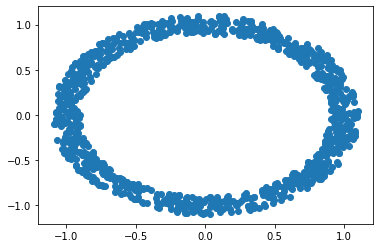

In [ ]:
angles = np.random.uniform(0, 2 * math.pi, size=[1024, 1])
r_rads = np.random.uniform(0.9, 1.1, size=[1024, 1])
x_train = np.hstack((np.cos(angles) * CIRCLE_RADIUS * r_rads, np.sin(angles) * CIRCLE_RADIUS * r_rads))


plt.scatter(x_train[:, 0], x_train[:, 1])

plt.show()

Train GAN.

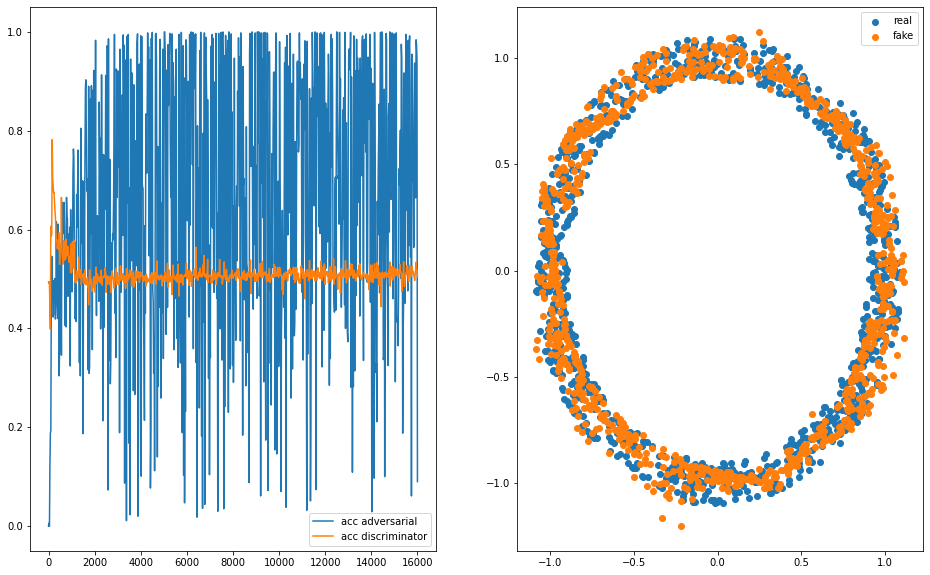

Objective score: 0.951


In [ ]:
vis_noise = np.random.normal(0, 1.0, size=[1000, SAMPLE_DIM])

acc_adv = []
acc_dis = []
plot_iteration = []

adversarial_stats = None
discriminator_stats = None

for i in range(ITERATIONS):
    generated = generator(vis_noise)
    mixed = tf.concat([generated, x_train], axis=0)
    y1 = tf.constant([[0.]] * generated.shape[0] + [[1.]] * x_train.shape[0])
    discriminator.trainable = True
    discriminator_stats = discriminator.train_on_batch(mixed, y1)

    y2 = tf.constant([[1.]] * vis_noise.shape[0])
    discriminator.trainable = False
    adversarial_stats = model.train_on_batch(vis_noise, y2)


    # Visualization: Plot the accuracy of the discriminator and the adversarial setup + the
    # predicted point cloud from the test vector.
    if i % 20 == 0:
        plot_iteration.append(i)
        # Don't forget to include the accuracy metric when compiling the models.
        acc_adv.append(adversarial_stats[1])
        acc_dis.append(discriminator_stats[1])

        clear_output(wait=True)

        fig, axes = plt.subplots(1,2)
        fig.set_size_inches(16, 10)

        axes[0].plot(plot_iteration, acc_adv, label="acc adversarial")
        axes[0].plot(plot_iteration, acc_dis, label="acc discriminator")
        axes[0].legend()

        # Visualize the performance of the generator by producing samples from the test vector.
        # generated = net_generator.predict(vis_noise)

        axes[1].scatter(x_train[:,0], x_train[:,1], label="real")
        axes[1].scatter(generated[:,0], generated[:,1], label="fake")
        axes[1].legend()
        plt.show()

        print("Objective score:", ring_objective(generated))


### MNIST GAN

In [ ]:
ITERATIONS = 10001
# I suggest using uniform random noise vectors of size 100.
SAMPLE_DIM = 100

Define discriminator architecture.

In [ ]:
def discriminator2():
    net = Sequential()
    net.add(Conv2D(32, kernel_size=5, strides=2, padding="same",activation=LeakyReLU(0.2), input_shape=[28, 28, 1]))
    net.add(Dropout(0.4))
    net.add(Conv2D(64, kernel_size=5, strides=2, padding="same", activation=LeakyReLU(0.2)))
    net.add(Dropout(0.4))
    net.add(Flatten())
    net.add(Dense(1, activation="sigmoid"))

    return net

Define generator architecture.

In [ ]:
def generator2():
    net = Sequential()
    net.add(Dense(7 * 7 * 64, input_shape=[SAMPLE_DIM]))
    net.add(LeakyReLU(alpha=0.2))
    net.add(Reshape([7, 7, 64]))
    net.add(BatchNormalization())
    net.add(Conv2DTranspose(32, kernel_size=5, strides=2, padding="same", activation="selu"))
    net.add(BatchNormalization())
    net.add(Conv2DTranspose(1, kernel_size=5, strides=2, padding="same", activation="tanh")) 
    return net

Load mnist training data.

In [ ]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
# x_train = input_data.read_data_sets("mnist", one_hot=True).train.images
x_train = x_train.reshape(-1, 28, 28, 1).astype(np.float32)

11493376/11490434 [==============================] - 0s 0us/step


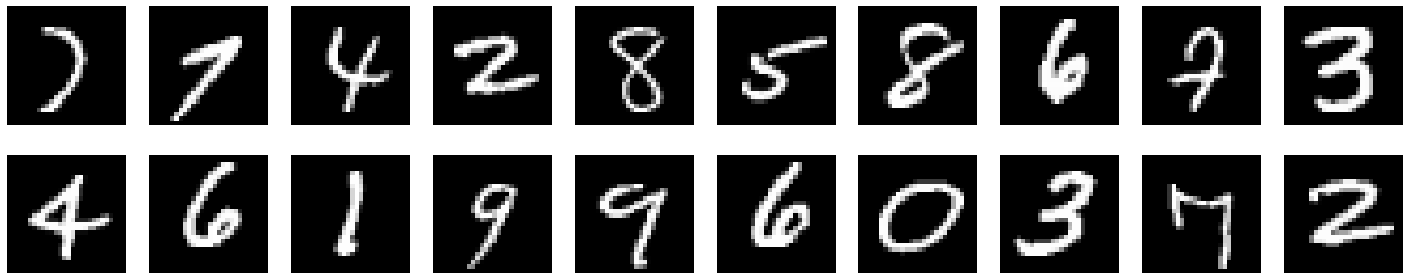

In [ ]:
images = x_train[140:160]

plt.figure(figsize=(25, 5))

for im in range(images.shape[0]):
    plt.subplot(2, 10, im + 1)
    image = images[im, :, :, :]
    image = np.reshape(image, [28, 28])

    plt.imshow(image, cmap='gray')
    plt.axis('off')

Train GAN.

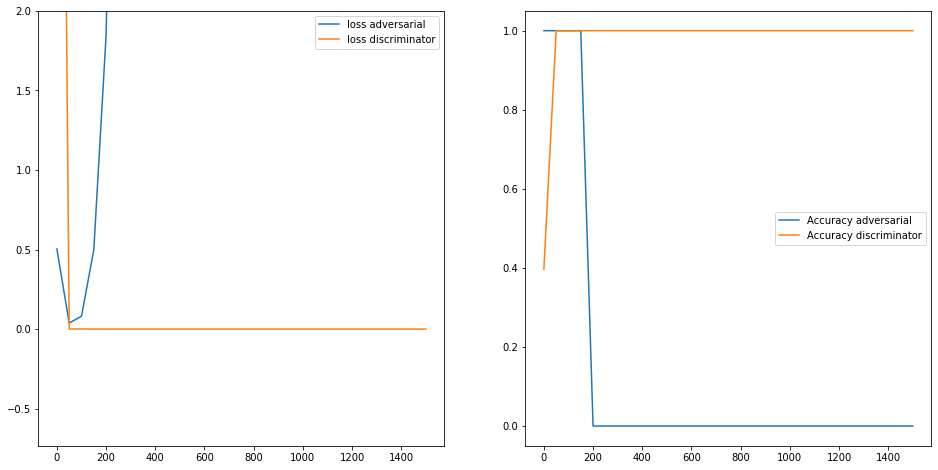

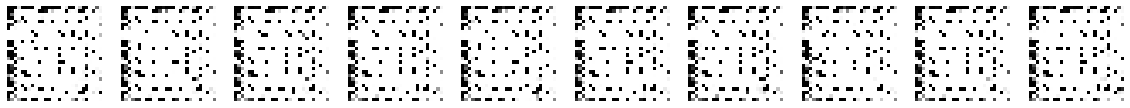

In [ ]:
loss_adv = []
loss_dis = []
acc_adv = []
acc_dis = []
plot_iteration = []

d_stats = None
a_stats = None

test_noise = np.random.uniform(-1.0, 1.0, size=[10, SAMPLE_DIM])
print(test_noise.shape)

discriminator = discriminator2()
generator = generator2()

discriminator.compile(loss="binary_crossentropy", optimizer="rmsprop", metrics=["accuracy"])
discriminator.trainable = False

model = Sequential([generator, discriminator])
model.compile(loss="binary_crossentropy", optimizer="rmsprop", metrics=["accuracy"])

for i in range(ITERATIONS):
    generated = generator(test_noise)
    mixed = tf.concat([generated, x_train], axis=0)
    y1 = tf.constant([[0.]] * generated.shape[0] + [[1.]] * x_train.shape[0])
    discriminator.trainable = True
    d_stats = discriminator.train_on_batch(mixed, y1)

    y2 = tf.constant([[1.]] * test_noise.shape[0])
    discriminator.trainable = False
    a_stats = model.train_on_batch(test_noise, y2)


    if i % 50 == 0:

        clear_output(wait=True)

        plot_iteration.append(i)
        loss_adv.append(a_stats[0])
        loss_dis.append(d_stats[0])
        acc_adv.append(a_stats[1])
        acc_dis.append(d_stats[1])

        fig, ax = plt.subplots(1,2)
        fig.set_size_inches(16, 8)

        ax[0].plot(plot_iteration, loss_adv, label="loss adversarial")
        ax[0].plot(plot_iteration, loss_dis, label="loss discriminator")
        ax[0].legend()
        ax[0].set_ylim(top=2)

        ax[1].plot(plot_iteration, acc_adv, label="Accuracy adversarial")
        ax[1].plot(plot_iteration, acc_dis, label="Accuracy discriminator")
        ax[1].legend()
        
        test_samples = generator.predict(test_noise)
        
        
        plt.figure(figsize=(20,10))

        for im in range(test_samples.shape[0]):
            plt.subplot(1, 10, im+1)
            image = test_samples[im, :, :, :]
            image = np.reshape(image, [28, 28])

            plt.imshow(image, cmap='gray')
            plt.axis('off')

        plt.show()


Das Model funktioniert vermutlich leider nicht. Einen sehr ähnlichen Vorgänger haben wir für etwa 1,5h trainiert ohne, dass sich etwas am Ergebniss gebessert hätte.